In [33]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import glob
import seaborn as sns
from sklearn.linear_model import LinearRegression
import cmocean
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap, addcyclic
import scipy.stats as sts
from matplotlib.ticker import FormatStrFormatter
import cartopy.feature as cfeature
import sklearn.covariance as skc
import sklearn.decomposition as skd
import scipy.signal as signal
from matplotlib import animation, rc
import nitime.algorithms as tsa
from IPython.display import HTML
%matplotlib inline

In [2]:
# setting data options
freq = ['aso','jfm','ann']
nssn = len(freq)
n100 = 8
nyrs = n100 * 100
ntim = nyrs * 12
pd = '.../aice/'
fns = sorted(glob.glob(pd + '*aice*.nc'))[:n100]

In [3]:
# extracting grid info
tmp = xr.open_dataset(fns[0],decode_times=False)
tlat = tmp['TLAT'].data
tlon = tmp['TLON'].data
tarea = tmp['tarea'].data
nlat = tlat.shape[0]
nlon = tlat.shape[1]

In [4]:
# extracting sea ice concentration and calculating sh SIA and sectorial SIA
tmp = xr.open_mfdataset(fns,concat_dim='time',decode_times=False)
aice = tmp['aice'].data/100.
aice[aice <= 0.15] = np.nan
tarea_3d = np.array([tarea for i in range(ntim)])
tarea_3d[np.isnan(aice)] = np.nan

sh_siarea = np.ones(ntim)*np.nan
sh_sect_siarea = np.ones([ntim,nlon])*np.nan

sh_siarea = np.nansum(np.nansum(aice*tarea_3d,axis=-1),axis=-1)
sh_sect_siarea = np.nansum(aice*tarea_3d,axis=1)

/data/tarunverma/my_utilities/anaconda2/lib/python2.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


In [5]:
sh_siarea_anom = sh_siarea.reshape([nyrs,12])
sh_siarea_anom = sh_siarea_anom - sh_siarea_anom.mean(axis=0)
sh_siarea_anom = sh_siarea_anom.reshape(ntim)

In [6]:
sh_sect_siarea_anom = sh_sect_siarea.reshape([nyrs,12,320])
sh_sect_siarea_anom = sh_sect_siarea_anom - sh_sect_siarea_anom.mean(axis=0)
sh_sect_siarea_anom = sh_sect_siarea_anom.reshape([ntim,320])

In [7]:
sh_siarea_ssn_anom = np.ones([nssn,nyrs])*np.nan
tmp = sh_siarea_anom.reshape([nyrs,12])
for i in range(nssn):
    f = freq[i]
    if f == 'aso':
        sh_siarea_ssn_anom[i,:] = tmp[:,7:10].mean(axis=1)
    if f == 'jfm':
        sh_siarea_ssn_anom[i,:] = tmp[:,0:3].mean(axis=1)
    if f == 'ann':
        sh_siarea_ssn_anom[i,:] = tmp[:,:].mean(axis=1)

In [8]:
sh_sect_siarea_ssn_anom = np.ones([nssn,nyrs,nlon])*np.nan
tmp = sh_sect_siarea_anom.reshape([nyrs,12,nlon])
for i in range(nssn):
    f = freq[i]
    if f == 'aso':
        sh_sect_siarea_ssn_anom[i,:] = tmp[:,7:10].mean(axis=1)
    if f == 'jfm':
        sh_sect_siarea_ssn_anom[i,:] = tmp[:,0:3].mean(axis=1)
    if f == 'ann':
        sh_sect_siarea_ssn_anom[i,:] = tmp[:,:].mean(axis=1)

In [9]:
def runningMeanFast(x, N):
    if len(x.shape) == 1:
        return np.convolve(x, np.ones((N,))/N,'same')[int(N/2):-int(N/2)+1]
    elif len(x.shape) == 2:
        n = x.shape[0]
        tmp = np.ones([n,x.shape[1]-N+1])
        for i in range(n):
            tmp[i] = np.convolve(x[i], np.ones((N,))/N,'same')[int(N/2):-int(N/2)+1]
        
        return tmp

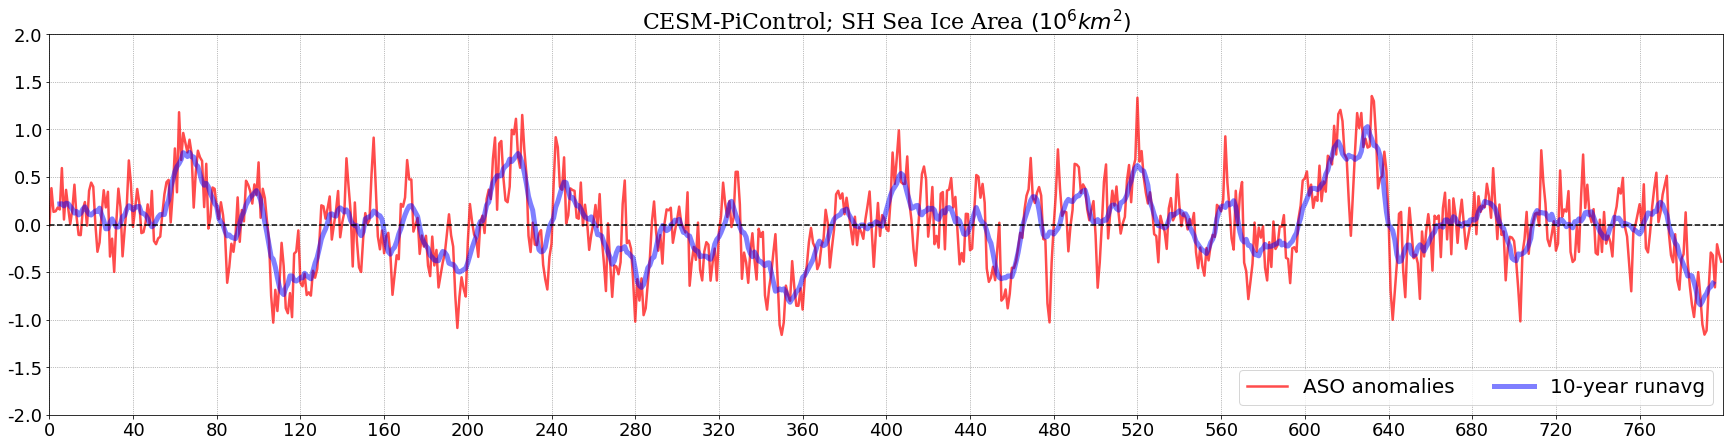

In [10]:
fig = plt.figure(figsize=(30,7))
ax = fig.add_subplot(111)

ax.plot(range(800),sh_siarea_ssn_anom[0,:800]*1e-12,'r-',lw=2.5,alpha=.7,label='ASO anomalies')
ax.plot(range(5,796),runningMeanFast(sh_siarea_ssn_anom[0,:800],10)*1e-12,'b-',lw=5.,alpha=.5,label='10-year runavg')
#ax.plot(range(60,4741),runningMeanFast(sh_siarea_anom[:4800],120)*1e-12,'b-',lw=3.,alpha=.5,label='120-month runavg')
#ax.plot(range(0,800-ntr+1),model.coef_[:,0]*1e-11,'k--')
ax.set_xticks(range(0,800,40));
ax.set_xticklabels(range(0,800,40),fontsize=18)
ax.set_xlim(0,800)
ax.set_ylim([-2.,2.])
ax.plot([0,800],[0,0],'k--')
ax.set_yticklabels(ax.get_yticks(),fontsize=18)
ax.set_title(r'CESM-PiControl; SH Sea Ice Area $(10^{6}km^2)$',fontsize=22,family='serif')
ax.grid(linestyle=':',linewidth=.7,color='grey')
ax.legend(loc=4,fontsize=20,ncol=2)

In [11]:
ntr = 5
model_5 = LinearRegression()
X = [i for i in range(0, ntr)]
X = np.reshape(X, (len(X), 1))
tmp = np.ones([nyrs-ntr+1,ntr])*np.nan
for i in range(nyrs-ntr+1):
    tmp[i] = sh_siarea_ssn_anom[0,i:i+ntr]
    
model_5.fit(X,tmp.T);

In [12]:
peaks_5_ind = signal.find_peaks(model_5.coef_[:,0],distance=5)[0]
peaks_5 = model_5.coef_[:,0][peaks_5_ind]
peaks_5_ind = peaks_5_ind[peaks_5 > 0]
peaks_5 = peaks_5[peaks_5>0]
n = peaks_5.shape[0]
th_5 = np.sort(peaks_5)[np.int(n*.75)]

In [13]:
dips_5_ind = signal.find_peaks(-model_5.coef_[:,0],distance=5)[0]
dips_5 = model_5.coef_[:,0][dips_5_ind]
dips_5_ind = dips_5_ind[dips_5 < 0]
dips_5 = dips_5[dips_5<0]
n = dips_5.shape[0]
print n
th_m5 = np.sort(dips_5)[np.int(n*.25)]

101


In [14]:
low_5,ind_low_5 = np.histogram(np.argsort(model_5.coef_[:,0])[:40],bins=range(0,840,40))
high_5,ind_high_5 = np.histogram(np.argsort(model_5.coef_[:,0])[-40:],bins=range(0,840,40))

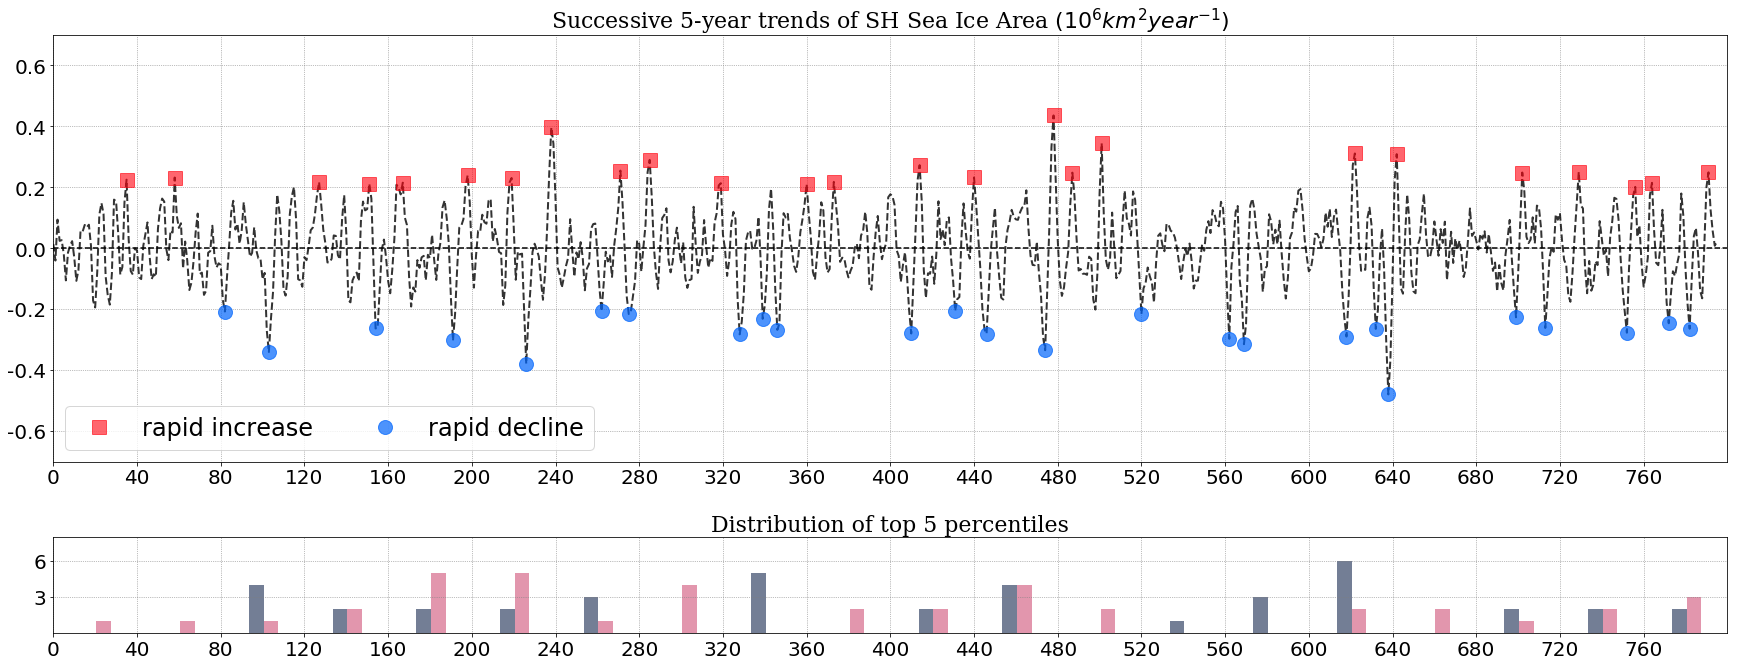

In [15]:
fig = plt.figure(figsize=(30,11))
gs = gridspec.GridSpec(105,100)
ax = fig.add_subplot(gs[:75,:])
ax1 = fig.add_subplot(gs[88:,:])
ax.plot(range(0,800-ntr+1),model_5.coef_[:,0]*1e-12,'k--',lw=2.,alpha=.8)
ax.plot(peaks_5_ind[peaks_5 >th_5],peaks_5[peaks_5>th_5]*1e-12,'s',color=sns.xkcd_rgb['bright red'],alpha=.6,ms=14.,label='rapid increase')
ax.plot(dips_5_ind[dips_5 < th_m5],dips_5[dips_5 < th_m5]*1e-12,'o',color=sns.xkcd_rgb['bright blue'],alpha=.7,ms=14.,label='rapid decline')

ax.set_xticks(range(0,800,40));
ax.set_xticklabels(range(0,800,40),fontsize=20)
ax.set_xlim(0,800)
ax.set_ylim([-.7,.7])
ax.plot([0,800],[0,0],'k--')
ax.set_yticklabels(ax.get_yticks(),fontsize=20)
ax.set_title(r'Successive 5-year trends of SH Sea Ice Area $(10^{6}km^2 year^{-1})$',fontsize=22,family='serif')
ax.grid(linestyle=':',linewidth=.7,color='grey')
ax.legend(loc=3,fontsize=24,ncol=2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.sca(ax1)
                          
plt.bar(list(ind_low_5[:-1]+17),list(low_5[:]),  width=7,color=sns.xkcd_rgb['navy'],alpha=.55)
plt.bar(list(ind_high_5[:-1]+24),list(high_5[:]), width=7,color=sns.xkcd_rgb['dark pink'],alpha=.55)
ax1.set_title(r'Distribution of top 5 percentiles',fontsize=22,family='serif')

ax1.set_xticks(range(0,800,40));
ax1.set_xticklabels(range(0,800,40),fontsize=20)
ax1.set_xlim(0,800)
ax1.grid(linestyle=':',linewidth=.7,color='grey')
ax1.set_yticks([3,6])
ax1.set_yticklabels([3,6],fontsize=20)
ax1.set_ylim(0,8)


In [16]:
ntr = 30
model_30 = LinearRegression()
X = [i for i in range(0, ntr)]
X = np.reshape(X, (len(X), 1))
tmp = np.ones([nyrs-ntr+1,ntr])*np.nan
for i in range(nyrs-ntr+1):
    tmp[i] = sh_siarea_ssn_anom[0,i:i+ntr]
    
model_30.fit(X,tmp.T)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [17]:
peaks_30_ind = signal.find_peaks(model_30.coef_[:,0],distance=30)[0]
peaks_30 = model_30.coef_[:,0][peaks_30_ind]
peaks_30_ind = peaks_30_ind[peaks_30 > 0]
peaks_30 = peaks_30[peaks_30>0]
n = peaks_30.shape[0]
th_30 = np.sort(peaks_30)[np.int(n*.65)]

In [18]:
dips_30_ind = signal.find_peaks(-model_30.coef_[:,0],distance=30)[0]
dips_30 = model_30.coef_[:,0][dips_30_ind]
dips_30_ind = dips_30_ind[dips_30 < 0]
dips_30 = dips_30[dips_30 < 0]
n = dips_30.shape[0]
th_m30 = np.sort(dips_30)[np.int(n*.35)]

In [19]:
low_30,ind_low_30 = np.histogram(np.argsort(model_30.coef_[:,0])[:40],bins=range(0,840,40))
high_30,ind_high_30 = np.histogram(np.argsort(model_30.coef_[:,0])[-40:],bins=range(0,840,40))

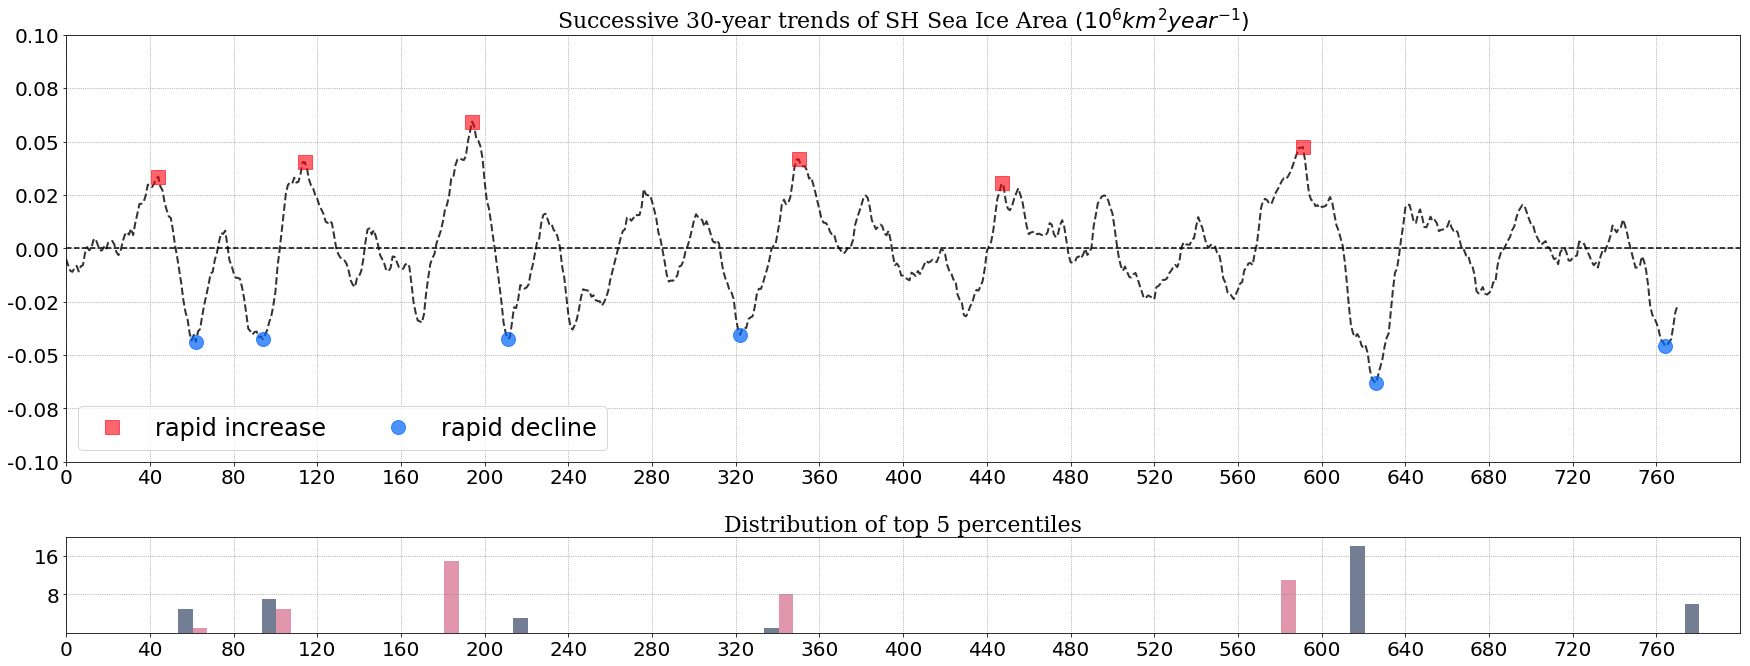

In [20]:
fig = plt.figure(figsize=(30,11))
gs = gridspec.GridSpec(105,100)
ax = fig.add_subplot(gs[:75,:])
ax1 = fig.add_subplot(gs[88:,:])
ax.plot(range(0,800-ntr+1),model_30.coef_[:,0]*1e-12,'k--',lw=2.,alpha=.8)
ax.plot(peaks_30_ind[peaks_30 >th_30],peaks_30[peaks_30>th_30]*1e-12,'s',color=sns.xkcd_rgb['bright red'],alpha=.6,ms=14.,label='rapid increase')
ax.plot(dips_30_ind[dips_30 < th_m30],dips_30[dips_30 < th_m30]*1e-12,'o',color=sns.xkcd_rgb['bright blue'],alpha=.7,ms=14.,label='rapid decline')

ax.set_xticks(range(0,800,40));
ax.set_xticklabels(range(0,800,40),fontsize=20)
ax.set_xlim(0,800)
ax.set_ylim([-.1,.1])
ax.plot([0,800],[0,0],'k--')
ax.set_yticklabels(ax.get_yticks(),fontsize=20)
ax.set_title(r'Successive 30-year trends of SH Sea Ice Area $(10^{6}km^2 year^{-1})$',fontsize=22,family='serif')
ax.grid(linestyle=':',linewidth=.7,color='grey')
ax.legend(loc=3,fontsize=24,ncol=2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.sca(ax1)
                          
plt.bar(list(ind_low_30[:-1]+17),list(low_30[:]),  width=7,color=sns.xkcd_rgb['navy'],alpha=.55)
plt.bar(list(ind_high_30[:-1]+24),list(high_30[:]), width=7,color=sns.xkcd_rgb['dark pink'],alpha=.55)
ax1.set_title(r'Distribution of top 5 percentiles',fontsize=22,family='serif')

ax1.set_xticks(range(0,800,40));
ax1.set_xticklabels(range(0,800,40),fontsize=20)
ax1.set_xlim(0,800)
ax1.grid(linestyle=':',linewidth=.7,color='grey')
ax1.set_yticks([8,16])
ax1.set_yticklabels([8,16],fontsize=20)
ax1.set_ylim(0,20)


In [21]:
def trans_data_2_ew_grid(zdat,lon):
    zdat_shift = np.ones_like(zdat)*np.nan
    lon_shift = np.ones_like(lon)*np.nan
    ind_l = np.argwhere(lon <= 180.)[-1][0]
    nind = lon[ind_l+1:].shape[0]
    tmp = np.where(np.greater(lon,180),lon-360,lon)
    lon_shift[:nind] = tmp[ind_l+1:]
    lon_shift[nind:] = tmp[:ind_l+1]
    if len(zdat.shape) == 2:
        zdat_shift[:,:nind] = zdat[:,ind_l+1:]
        zdat_shift[:,nind:] = zdat[:,:ind_l+1] 
    else:
        zdat_shift[:nind] = zdat[ind_l+1:]
        zdat_shift[nind:] = zdat[:ind_l+1]        
    
    return zdat_shift,lon_shift
    

In [22]:
tmp,lon = trans_data_2_ew_grid(sh_sect_siarea_ssn_anom[0],tlon[30])

In [25]:
pca = skd.PCA(n_components=6)
emp_pca_aso = pca.fit_transform(trans_data_2_ew_grid(sh_sect_siarea_ssn_anom[0],tlon[30])[0])
print pca.explained_variance_ratio_*100.

[32.68732005 19.22471306 11.51918442  8.73852144  7.18708017  4.4892192 ]


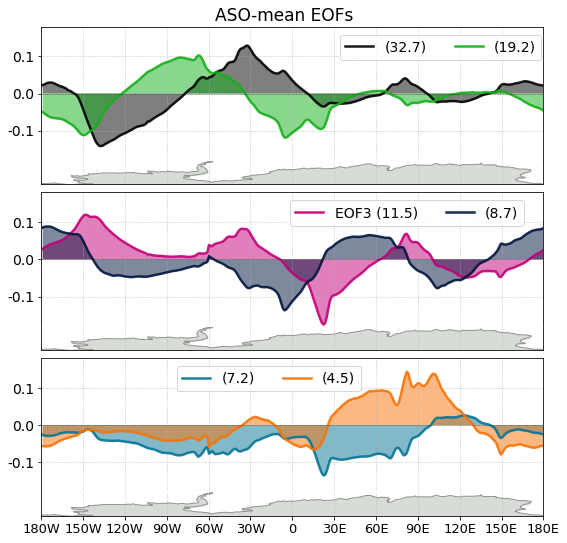

In [32]:
fig = plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(310,100)
ax1 = fig.add_subplot(gs[:85,:])
ax1m = fig.add_subplot(gs[85:100,:])

ax1.plot(lon,pca.components_[0],'-',color=sns.xkcd_rgb['black'],lw=2.5,alpha=.9,label='(%.1f)' %(pca.explained_variance_ratio_[0]*100.))
ax1.fill_between(lon,pca.components_[0],np.zeros_like(pca.components_[0]),facecolor=sns.xkcd_rgb['black'],alpha=.5)
ax1.plot(lon,pca.components_[1],'-',color=sns.xkcd_rgb['green'],lw=2.5,alpha=.9,label='(%.1f)' %(pca.explained_variance_ratio_[1]*100.))
ax1.fill_between(lon,pca.components_[1],np.zeros_like(pca.components_[0]),facecolor=sns.xkcd_rgb['green'],alpha=.5)

ax1.set_xticks(np.arange(-180,210,30))
ax1.set_xticklabels('',fontsize=13)
ax1.set_yticks(np.arange(-.1,.2,.1))
ax1.set_yticklabels(ax1.get_yticks(),fontsize=14)
ax1.set_xlim([-180,180])
ax1.set_ylim([-.18,.18])
ax1.legend(loc=4,fontsize=14,ncol=2,bbox_to_anchor=(1.01,.7))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.grid(linestyle=':',linewidth=.7)
ax1.plot([-180,180],[0,0],'k--',lw=.5,alpha=.6)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x', which='both', length=0)

for i,geom in enumerate(cfeature.COASTLINE.geometries()):
    if i == 98:
        for g in geom.geoms:
            ax1m.plot(*zip(*list(g.coords)),color=sns.xkcd_rgb['grey'],lw=1);
            n = len(zip(*list(g.coords))[1])
            ax1m.fill_between(zip(*list(g.coords))[0],np.ones(n)*-85.,zip(*list(g.coords))[1],color=sns.xkcd_rgb['light grey'])
ax1m.set_xlim(-180,180)
ax1m.set_yticks([10,20])
ax1m.set_ylim(-85,-63)
ax1m.set_xticks(np.arange(-180,210,30))
ax1m.set_xticklabels('',fontsize=13);
ax1m.grid(linestyle=':',linewidth=.7)
ax1m.spines['top'].set_visible(False)
ax1m.tick_params(axis='x', which='both', length=0)

ax2 = fig.add_subplot(gs[105:190,:])
ax2m = fig.add_subplot(gs[190:205,:])


ax2.plot(lon,pca.components_[2],'-',color=sns.xkcd_rgb['magenta'],lw=2.5,alpha=.9,label='EOF3 (%.1f)' %(pca.explained_variance_ratio_[2]*100.))
ax2.fill_between(lon,pca.components_[2],np.zeros_like(pca.components_[2]),facecolor=sns.xkcd_rgb['magenta'],alpha=.5)
ax2.plot(lon,pca.components_[3],'-',color=sns.xkcd_rgb['navy'],lw=2.5,alpha=.9,label='(%.1f)' %(pca.explained_variance_ratio_[3]*100.))
ax2.fill_between(lon,pca.components_[3],np.zeros_like(pca.components_[3]),facecolor=sns.xkcd_rgb['navy'],alpha=.5)

ax2.set_xticks(np.arange(-180,210,30))
ax2.set_xticklabels('',fontsize=13)
ax2.set_yticklabels(ax2.get_yticks(),fontsize=14)
ax2.set_xlim([-180,180])
ax2.set_ylim([-.18,.18])
ax2.legend(loc=4,fontsize=14,ncol=2,bbox_to_anchor=(.975,.7))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.grid(linestyle=':',linewidth=.7)
ax2.plot([-180,180],[0,0],'k--',lw=.5,alpha=.6)
ax2.spines['bottom'].set_visible(False)

ax2.tick_params(axis='x', which='both', length=0)

for i,geom in enumerate(cfeature.COASTLINE.geometries()):
    if i == 98:
        for g in geom.geoms:
            ax2m.plot(*zip(*list(g.coords)),color=sns.xkcd_rgb['grey'],lw=1);
            n = len(zip(*list(g.coords))[1])
            ax2m.fill_between(zip(*list(g.coords))[0],np.ones(n)*-85.,zip(*list(g.coords))[1],color=sns.xkcd_rgb['light grey'])
ax2m.set_xlim(-180,180)
ax2m.set_yticks([10,20])
ax2m.set_ylim(-85,-63)
ax2m.set_xticks(np.arange(-180,210,30))
ax2m.set_xticklabels('',fontsize=13);
ax2m.grid(linestyle=':',linewidth=.7)
ax2m.spines['top'].set_visible(False)
ax2m.tick_params(axis='x', which='both', length=0)

ax3 = fig.add_subplot(gs[210:295,:])
ax3m = fig.add_subplot(gs[295:310,:])

ax3.plot(lon,pca.components_[4],'-',color=sns.xkcd_rgb['sea blue'],lw=2.5,alpha=.9,label='(%.1f)' %(pca.explained_variance_ratio_[4]*100.))
ax3.fill_between(lon,pca.components_[4],np.zeros_like(pca.components_[4]),facecolor=sns.xkcd_rgb['sea blue'],alpha=.5)


ax3.plot(lon,pca.components_[5],'-',color=sns.xkcd_rgb['orange'],lw=2.5,alpha=.9,label='(%.1f)' %(pca.explained_variance_ratio_[5]*100.))
ax3.fill_between(lon,pca.components_[5],np.zeros_like(pca.components_[5]),facecolor=sns.xkcd_rgb['orange'],alpha=.5)

ax3.set_xticks(np.arange(-180,210,30))
ax3.set_xticklabels('',fontsize=13)
ax3.set_yticklabels(ax3.get_yticks(),fontsize=14)
ax3.set_xlim([-180,180])
ax3.set_ylim([-.18,.18])
ax3.legend(loc=4,fontsize=14,ncol=2,bbox_to_anchor=(.65,.7))
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax3.grid(linestyle=':',linewidth=.7)
ax3.plot([-180,180],[0,0],'k--',lw=.5,alpha=.6)
ax3.spines['bottom'].set_visible(False)

ax3.tick_params(axis='x', which='both', length=0)

for i,geom in enumerate(cfeature.COASTLINE.geometries()):
    if i == 98:
        for g in geom.geoms:
            ax3m.plot(*zip(*list(g.coords)),color=sns.xkcd_rgb['grey'],lw=1);
            n = len(zip(*list(g.coords))[1])
            ax3m.fill_between(zip(*list(g.coords))[0],np.ones(n)*-85.,zip(*list(g.coords))[1],color=sns.xkcd_rgb['light grey'])
ax3m.set_xlim(-180,180)
ax3m.set_yticks([10,20])
ax3m.set_ylim(-85,-63)
ax3m.set_xticks(np.arange(-180,210,30))
ax3m.set_xticklabels(['180W','150W','120W','90W','60W','30W','0','30E','60E','90E','120E','150E','180E'],fontsize=13);
ax3m.grid(linestyle=':',linewidth=.7)
ax3m.spines['top'].set_visible(False)
#ax3m.tick_params(axis='x', which='both', length=0)

fig.suptitle('ASO-mean EOFs', x=0.5, y=.91, horizontalalignment='center', verticalalignment='top', fontsize = 17)


In [34]:
pca = skd.PCA(n_components=20)
emp_pca_aso = pca.fit_transform(trans_data_2_ew_grid(sh_sect_siarea_ssn_anom[0],tlon[30])[0])
print pca.explained_variance_ratio_*100.

[32.68732005 19.22471306 11.51918442  8.73852144  7.18708017  4.4892192
  3.50531851  2.41581016  2.15676599  1.54574772  1.18279334  0.70490229
  0.66004087  0.61020228  0.41051537  0.40000133  0.3385677   0.28823725
  0.21632605  0.18882191]


In [165]:
ne = 20
orig_dat = trans_data_2_ew_grid(sh_sect_siarea_ssn_anom[0],tlon[30])[0]
recon_dat = np.ones([ne+1,nyrs,nlon])*np.nan
recon_error = np.ones([ne+1,nlon])*np.nan
for i in range(ne):
    pca = skd.PCA(n_components=i)
    emp_pca_aso = pca.fit_transform(orig_dat)
    recon_dat[i] = pca.inverse_transform(emp_pca_aso)
    recon_error[i] = np.sqrt(((orig_dat - recon_dat[i])**2).mean(axis=0))
    
pca = skd.PCA(n_components=100)
emp_pca_aso = pca.fit_transform(orig_dat)
recon_dat[-1] = pca.inverse_transform(emp_pca_aso)
recon_error[-1] = np.sqrt(((orig_dat - recon_dat[-1])**2).mean(axis=0))

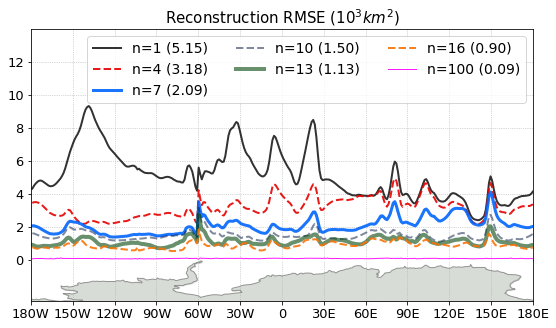

In [173]:
fig = plt.figure(figsize=(9,5))
gs = gridspec.GridSpec(100,100)
ax = fig.add_subplot(gs[:85,:])
ax_m = fig.add_subplot(gs[85:,:])
cols = [sns.xkcd_rgb['black'],sns.xkcd_rgb['red'],sns.xkcd_rgb['bright blue'],sns.xkcd_rgb['navy'],sns.xkcd_rgb['forest green'],\
       sns.xkcd_rgb['orange'],]
lws = [2,2.,3,2,4,2]
ls = ['-','--','-','--','-','--']
als = [.8,.9,.9,.5,.6,.9]
for i in range(ne)[:-3:3]:
    ax.plot(lon,recon_error[i]*1e-9,lw=lws[i/3],ls=ls[i/3],color=cols[i/3],alpha=als[i/3],label='n=' + str(i+1) + ' (%.2f)' %(recon_error[i].mean()*1e-9))
    
ax.plot(lon,recon_error[-1]*1e-9,lw=1,ls='-',color='magenta',alpha=.9,label='n=100' + ' (%.2f)' %(recon_error[-1].mean()*1e-9))

ax.legend(loc='best',ncol=3,fontsize=14)
ax.grid(linestyle=':',linewidth=.7)
ax.set_xticks(np.arange(-180,210,30))
ax.set_xticklabels('',fontsize=13);
ax.set_xlim(-180,180)
ax.set_yticks(np.arange(0,14,2))
ax.set_yticklabels(ax.get_yticks(),fontsize=13)
ax.set_ylim([0,14])
ax.set_title('Reconstruction RMSE ($10^3km^2$)',fontsize=15)

ax.tick_params(axis='x', which='both', length=0)
ax.spines['bottom'].set_visible(False)

for i,geom in enumerate(cfeature.COASTLINE.geometries()):
    if i == 98:
        for g in geom.geoms:
            ax_m.plot(*zip(*list(g.coords)),color=sns.xkcd_rgb['grey'],lw=1);
            n = len(zip(*list(g.coords))[1])
            ax_m.fill_between(zip(*list(g.coords))[0],np.ones(n)*-85.,zip(*list(g.coords))[1],color=sns.xkcd_rgb['light grey'])
ax_m.set_xlim(-180,180)
ax_m.set_yticks([10,20])
ax_m.set_ylim(-85,-63)
ax_m.set_xticks(np.arange(-180,210,30))
ax_m.set_xticklabels(['180W','150W','120W','90W','60W','30W','0','30E','60E','90E','120E','150E','180E'],fontsize=13);
ax_m.grid(linestyle=':',linewidth=.7)
ax_m.spines['top'].set_visible(False)


In [1452]:
def mtem(i, j):
    #print 'i size', i.shape
    #print 'j size', j.shape
    
    # apply multi taper cross spectral density from nitime module
    f, pcsd_est = tsa.multi_taper_csd(np.vstack([i,j]), Fs=1.,NW=20, adaptive=True, sides='onesided')
    
    # output is MxMxN matrix, extract the psd and csd
    fki = pcsd_est.diagonal().T[0]
    fkj = pcsd_est.diagonal().T[1]
    cij = pcsd_est.diagonal(+1).T.ravel()
    
    # using complex argument of cxy extract phase component
    ph = np.angle(cij)
    
    # calculate coherence using csd and psd
    coh = np.abs(cij)**2 / (fki * fkj)   
    
    return f, fki, fkj, cij, ph, coh 

In [1361]:
x = np.ones([8,800])*np.nan
tmp = sh_siarea_ssn_anom[0] - sh_siarea_ssn_anom[0].mean()
x[0] = tmp/np.std(tmp,ddof=1)
x[1:] = (emp_pca_aso[:,:7]/emp_pca_aso[:,:7].std(axis=0)).T
y = np.copy(x)

In [1455]:
f, fki, fkj, cij, ph, coh = mtem(x[1],x[2])

In [1460]:
rad2time = ph[1:]/(2*np.pi*f[1:])

In [1486]:
ttl = ['Area','PC1 (%.1f)' %(pca.explained_variance_ratio_[0]*100),'PC2 (%.1f)' %(pca.explained_variance_ratio_[1]*100)]
ttl = ttl + ['PC3 (%.1f)' %(pca.explained_variance_ratio_[2]*100),'PC4 (%.1f)' %(pca.explained_variance_ratio_[3]*100)]
ttl = ttl + ['PC5 (%.1f)' %(pca.explained_variance_ratio_[4]*100),'PC6 (%.1f)' %(pca.explained_variance_ratio_[5]*100)]
ttl = ttl + ['PC7 (%.1f)' %(pca.explained_variance_ratio_[6]*100)]
print ttl


['Area', 'PC1 (32.7)', 'PC2 (19.2)', 'PC3 (11.5)', 'PC4 (8.7)', 'PC5 (7.2)', 'PC6 (4.5)', 'PC7 (3.5)']


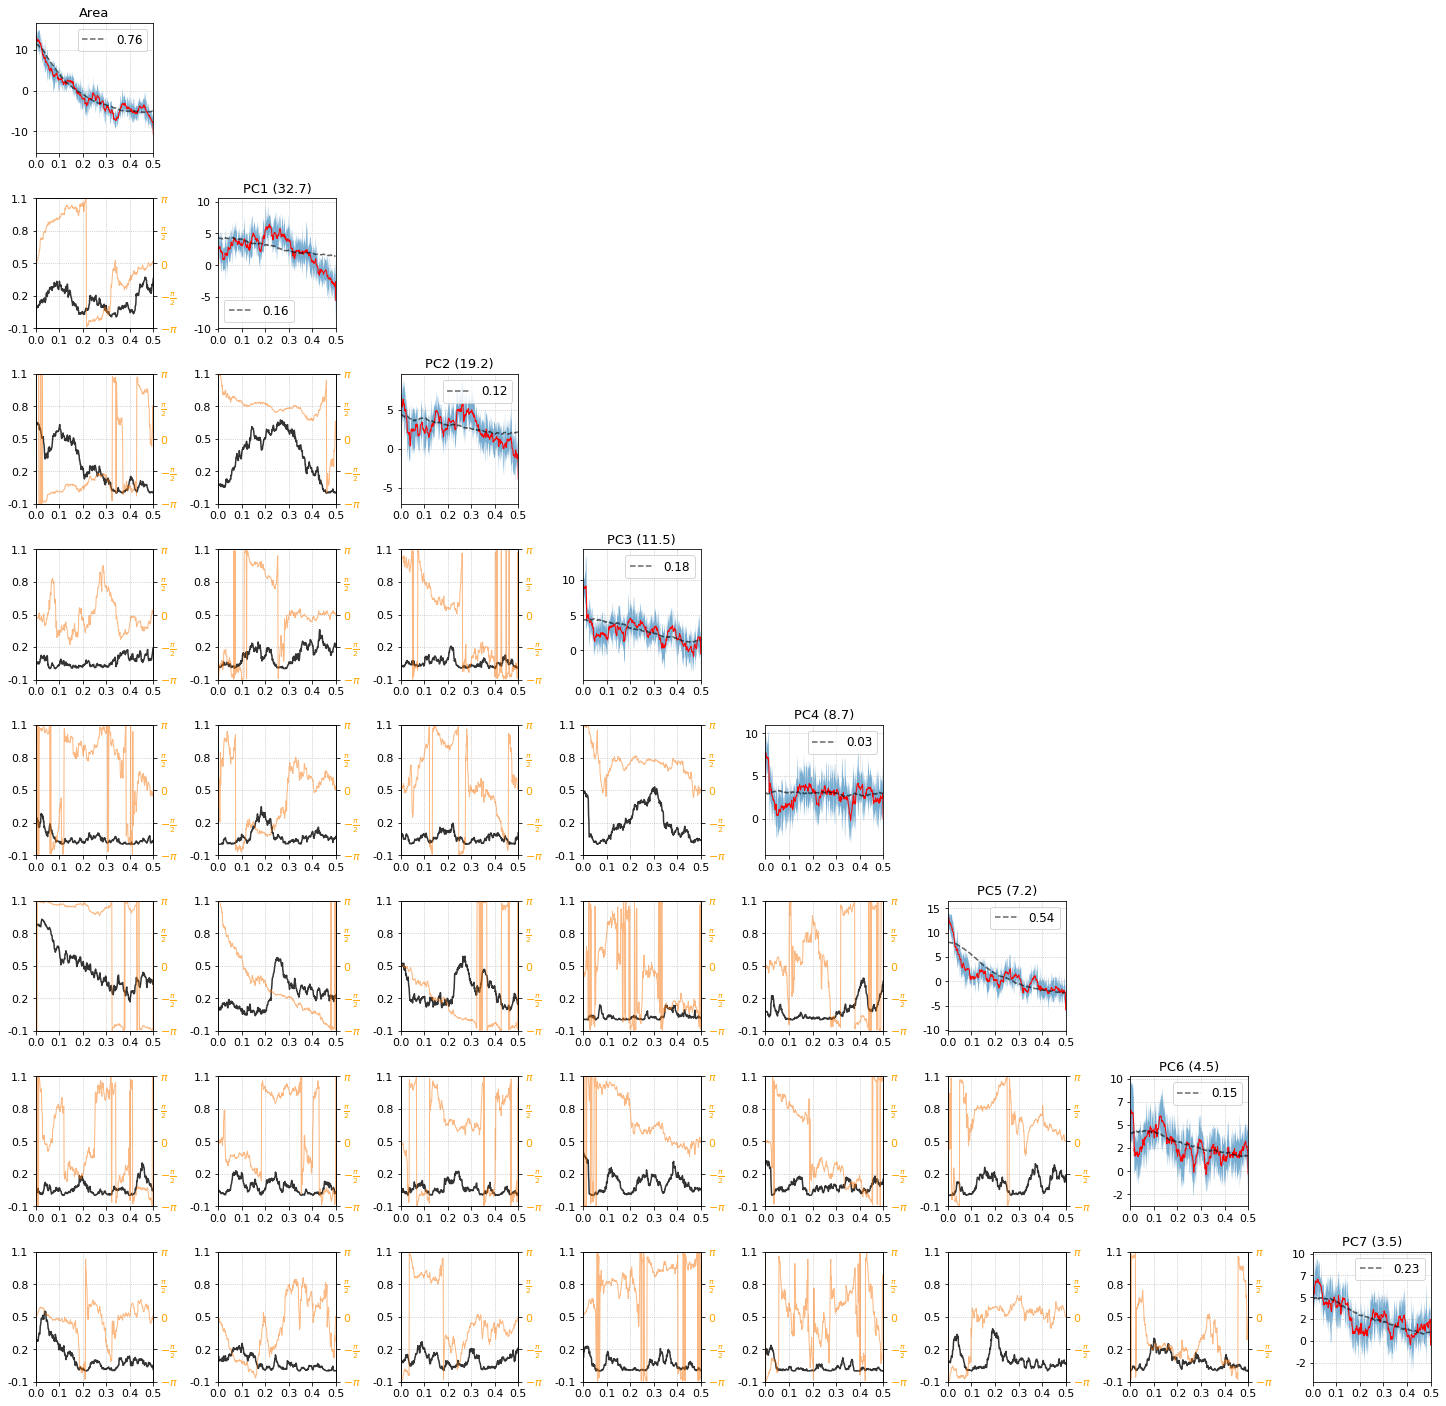

In [1488]:
fig = plt.figure(figsize=(25,25))
plt.subplots_adjust(wspace=.55,hspace=.35)
n = 8
tot = n**2

for i in range(n)[:]:
    for j in range(n)[:]:
        if i > j:
            ax = fig.add_subplot(n,n,i*n + j+1)
            ax_m = ax.twinx()
            plt.sca(ax)
            f, fki, fkj, cij, ph, coh = mtem(x[i],x[j])
            plt.plot(f,coh,'-',color=sns.xkcd_rgb['black'],lw=1.5,alpha=.8)
            plt.xlim(0,.5)
            plt.ylim(-.1,1.1)
            plt.xticks(np.arange(0,.6,.1))
            ax.set_yticks(np.arange(-0.1,1.2,.3))
            ax.set_yticklabels(ax.get_yticks(),fontsize=11)
            plt.ylim(-.1,1.1)
            ax.set_xticklabels(np.arange(0,.6,.1),fontsize=11)
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            plt.grid(linestyle=':',linewidth=.7)
            ax_m.plot(f,ph*180./np.pi,'-',color=sns.xkcd_rgb['orange'],lw=1.,alpha=.5)
            ax_m.set_yticks(np.arange(-180,270,90))
            ax_m.set_yticklabels(['$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'],fontsize=11)
            #ax_m.yaxis.set_major_formatter(FormatStrFormatter('%1d'))
            ax_m.set_ylim(-180,180)
            for tl in ax_m.get_yticklabels():
                tl.set_color('orange')

            
        if i == j:
            ax = fig.add_subplot(n,n,i*n + j+1)
            plt.sca(ax)
            corr = np.corrcoef(x[i,:-1],x[j,1:])[0,1]
            var = np.var(x[i],ddof=1)
            #print corr,var,x[i].mean()
            ar1 = np.zeros(401)
            for m in range(30):
                w = np.random.randn(800)
                r = np.ones_like(w)*np.nan
                r[0] = w[0]
                for k in range(1,800):
                    r[k] = corr*r[k-1] + np.sqrt(1-corr**2)*w[k]
                
                r = r-r.mean()
                fgr,tmp = tsa.multi_taper_psd(r,Fs=1.,adaptive=True,NW=20)[:2]
                ar1 = ar1 + tmp
                
            ar1 /=30.
            a,b,c = tsa.multi_taper_psd(x[i],Fs=1.,NW=12,adaptive=True,jackknife=True)
            jk_p = (dist.t.ppf(.95, 24 - 1) * np.sqrt(c)) * ln2db
            jk_limits = (dB(b) - dB(jk_p), dB(b) + dB(jk_p))
            plt.plot(a,dB(b),'r-',lw=1.)
            plt.fill_between(a,jk_limits[0],jk_limits[1],alpha=.6)
            plt.plot(fgr[1:-1],dB(ar1[1:-1]),'k--',alpha=.6,lw=1.5,label='%.2f' % (corr))
            plt.xlim(0.0,.5)
            plt.xticks(np.arange(0,.6,.1))
            ax.set_title(ttl[i],fontsize=13)
            ax.set_xticklabels(np.arange(0,.6,.1),fontsize=11)
            ax.set_yticklabels(ax.get_yticks(),fontsize=11)
            plt.grid(linestyle=':',linewidth=.7)
            plt.legend(loc='best',fontsize=12)
            ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    
